# 📊 Estructura de Implementación de Machine Learning

## 🎯 Objetivo
Estructurar el flujo de trabajo de Machine Learning para asegurar un proceso:
* Robusto
* Reproducible
* Fácil de entender

## 📝 Estructura del Proceso

### 🛠️ Paso 0: Configuración
* Importación de herramientas necesarias:
  * pandas para datos
  * sklearn para preprocesamiento, modelos y métricas
  * seaborn/matplotlib para gráficos

### 📥 Paso 1: Carga y Preparación de Datos
* Carga del CSV original
* Definición del problema de clasificación (predecir Demand Trend)
* Feature Engineering:
  * Extracción de Month y DayOfWeek de Date
* Separación de variables:
  * X (features)
  * y (target)
* Codificación del Target:
  * Conversión de texto a números (0, 1, 2) usando LabelEncoder

### 🔧 Paso 2: Pipeline de Preprocesamiento
* Identificación de columnas:
  * numeric_features (ej. Price)
  * categorical_features (ej. Promotions)
* Transformaciones:
  * StandardScaler para numéricas
  * OneHotEncoder para categóricas
* Unificación con ColumnTransformer

### 📊 Paso 3: División de Datos
* Distribución:
  * 80% entrenamiento
  * 20% prueba
* Características:
  * Aprendizaje solo con datos de entrenamiento
  * Evaluación imparcial con datos de prueba
  * Uso de stratify=y para balance de clases

### 🤖 Paso 4: Implementación y Evaluación
* Pipeline para cada modelo:
  * preprocessor + classifier
* Modelos implementados:
  * Árbol de Decisión (base)
  * SVM (con GridSearchCV)
  * Random Forest (ensemble)
* Métricas evaluadas:
  * Precisión
  * Recall
  * F1-Score
* Visualización:
  * Matriz de Confusión

### 📈 Paso 5: Comparación Experimental
* Tabla resumen con resultados
* Visualización comparativa:
  * Gráfico de barras
  * Rendimiento por modelo y métrica

In [12]:
# --- PASO 0: Configuración e Importación de Bibliotecas ---

# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Métricas y Visualización
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Configuraciones
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore') # Ocultar warnings para un reporte más limpio

In [13]:
# --- PASO 1: Carga y Preparación de Datos ---

# 1.1. Cargar el dataset
file_path = 'https://drive.google.com/uc?export=download&id=1EZdevUjCF_18ts11cJju7UC349OR_20i'
df = pd.read_csv(file_path)

# 1.2. Feature Engineering (similar al EDA)
# Convertimos 'Date' y extraemos características temporales
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

# 1.3. Definir X (features) e y (target)
# El objetivo (target) es 'Demand Trend'
TARGET = 'Demand Trend'

# 'Date' se elimina porque ya extrajimos su valor (Month, DayOfWeek, Year)
# 'Year' probablemente sea constante (vimos 2024 en el EDA), así que la quitamos.
# Vamos a verificar el año.
print(f"Valores únicos en 'Year': {df['Year'].unique()}")
# Confirmado, solo 2024. No aporta información.

# X = todas las columnas MENOS el target, 'Date' y 'Year'.
X = df.drop(columns=[TARGET, 'Date', 'Year']) 
y = df[TARGET]

# 1.4. Codificar la variable objetivo (y)
# Los modelos necesitan números, no texto ('Stable', 'Increasing', etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Guardamos las etiquetas para usarlas en los gráficos
class_labels = le.classes_
print(f"Clases del objetivo: {class_labels}")
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y_encoded.shape}")

Valores únicos en 'Year': [2024]
Clases del objetivo: ['Decreasing' 'Increasing' 'Stable']
Dimensiones de X: (10000, 10)
Dimensiones de y: (10000,)


In [14]:
# --- PASO 2: Definición del Pipeline de Preprocesamiento ---

# El preprocesamiento es clave. Usaremos ColumnTransformer para aplicar
# diferentes transformaciones a diferentes columnas.

# 2.1. Identificar tipos de columnas
# Columnas numéricas que necesitan ser 'escaladas'
numeric_features = ['Sales Quantity', 'Price', 'Month', 'DayOfWeek']

# Columnas categóricas que necesitan 'One-Hot Encoding'
# 'Product ID' y 'Store ID' tienen alta cardinalidad, pero OHE es un buen inicio.
categorical_features = ['Product ID', 'Store ID', 'Promotions', 
                        'Seasonality Factors', 'External Factors', 'Customer Segments']

# 2.2. Crear los transformadores
# Pipeline para variables numéricas: Escalar
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas: Codificar
categorical_transformer = Pipeline(steps=[
    # handle_unknown='ignore' evita errores si una categoría rara aparece en el test set
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# 2.3. Unir transformadores con ColumnTransformer
# Esta es la pieza central del preprocesamiento.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Deja pasar cualquier columna no especificada (aunque no hay)
)

print("\nPipeline de preprocesamiento creado.")


Pipeline de preprocesamiento creado.


In [15]:
# --- PASO 3: División en Conjunto de Entrenamiento y Prueba ---

# Dividimos los datos: 80% para entrenar, 20% para probar.
# random_state=42 asegura que la división sea siempre la misma (reproducibilidad).
# 'stratify=y_encoded' asegura que la proporción de clases (Stable, Increasing, etc.)
# sea la misma en el set de entrenamiento y prueba. ¡Crucial para clasificación!

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Tamaño de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de Prueba: {X_test.shape[0]} muestras")

Tamaño de Entrenamiento: 8000 muestras
Tamaño de Prueba: 2000 muestras



--- 1. Entrenando Árbol de Decisión ---
Resultados del Árbol de Decisión:
  Precision (Macro): 0.3305
  Recall (Macro):    0.3304
  F1-Score (Macro):  0.3304
              precision    recall  f1-score   support

  Decreasing       0.33      0.33      0.33       652
  Increasing       0.33      0.34      0.33       677
      Stable       0.34      0.33      0.33       671

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.33      0.33      0.33      2000

Resultados del Árbol de Decisión:
  Precision (Macro): 0.3305
  Recall (Macro):    0.3304
  F1-Score (Macro):  0.3304
              precision    recall  f1-score   support

  Decreasing       0.33      0.33      0.33       652
  Increasing       0.33      0.34      0.33       677
      Stable       0.34      0.33      0.33       671

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg    

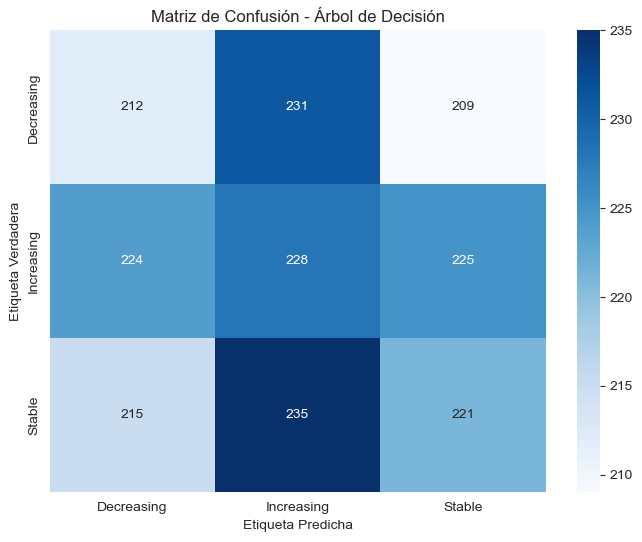

In [16]:
# --- PASO 4: Implementación y Evaluación de Clasificadores ---

# 4.0. Lista para guardar resultados para la comparación final
all_results = []

# Función auxiliar para graficar la Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# ---
# 4.1. Modelo 1: Árbol de Decisión (Decision Tree)
# ---
print("\n--- 1. Entrenando Árbol de Decisión ---")

# Creamos el pipeline completo: 1. Preprocesar, 2. Clasificar
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Entrenar el modelo
pipeline_dt.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_dt = pipeline_dt.predict(X_test)

# Evaluar
precision_dt = precision_score(y_test, y_pred_dt, average='macro')
recall_dt = recall_score(y_test, y_pred_dt, average='macro')
f1_dt = f1_score(y_test, y_pred_dt, average='macro')

print(f"Resultados del Árbol de Decisión:")
print(f"  Precision (Macro): {precision_dt:.4f}")
print(f"  Recall (Macro):    {recall_dt:.4f}")
print(f"  F1-Score (Macro):  {f1_dt:.4f}")
print(classification_report(y_test, y_pred_dt, target_names=class_labels))

# Guardar resultados
all_results.append({
    'Model': 'Decision Tree',
    'Precision': precision_dt,
    'Recall': recall_dt,
    'F1-Score': f1_dt
})

# Graficar Matriz de Confusión
plot_confusion_matrix(y_test, y_pred_dt, class_labels, 'Matriz de Confusión - Árbol de Decisión')


--- 2. Entrenando SVM (con GridSearchCV) ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros encontrados para SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Mejores parámetros encontrados para SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Resultados de SVM (Mejor Modelo):
  Precision (Macro): 0.3368
  Recall (Macro):    0.3367
  F1-Score (Macro):  0.3358
              precision    recall  f1-score   support

  Decreasing       0.34      0.33      0.33       652
  Increasing       0.34      0.39      0.36       677
      Stable       0.33      0.30      0.31       671

    accuracy                           0.34      2000
   macro avg       0.34      0.34      0.34      2000
weighted avg       0.34      0.34      0.34      2000

Resultados de SVM (Mejor Modelo):
  Precision (Macro): 0.3368
  Recall (Macro):    0.3367
  F1-Score (Macro):  0.3358
              precision    recall  f1-score   support

  Decreasing       0.34      0.33 

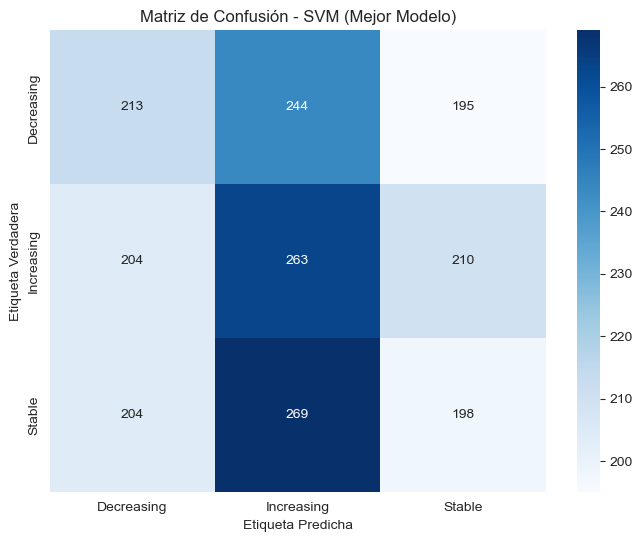

In [17]:
# ---
# 4.2. Modelo 2: SVM (con ajuste de kernel y C)
# ---
print("\n--- 2. Entrenando SVM (con GridSearchCV) ---")

# Creamos el pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True)) # probability=True es lento pero útil
])

# Definimos la parrilla de hiperparámetros a probar
# 'classifier__C' -> accede al parámetro 'C' del paso 'classifier'
param_grid_svm = {
    'classifier__C': [0.1, 1], # Valores de regularización
    'classifier__kernel': ['linear', 'rbf'] # Tipos de kernel
}

# Configurar GridSearchCV
# cv=3 (Cross-validation de 3 folds)
# scoring='f1_macro' -> optimizamos para F1-score (bueno para clasificación multiclase)
# n_jobs=-1 -> usa todos los procesadores
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

# Entrenar el GridSearchCV (esto puede tardar unos minutos)
grid_svm.fit(X_train, y_train)

print(f"Mejores parámetros encontrados para SVM: {grid_svm.best_params_}")

# Usar el mejor modelo encontrado para predecir
y_pred_svm = grid_svm.predict(X_test)

# Evaluar
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')

print(f"Resultados de SVM (Mejor Modelo):")
print(f"  Precision (Macro): {precision_svm:.4f}")
print(f"  Recall (Macro):    {recall_svm:.4f}")
print(f"  F1-Score (Macro):  {f1_svm:.4f}")
print(classification_report(y_test, y_pred_svm, target_names=class_labels))

# Guardar resultados
all_results.append({
    'Model': 'SVM (Tuned)',
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm
})

# Graficar Matriz de Confusión
plot_confusion_matrix(y_test, y_pred_svm, class_labels, 'Matriz de Confusión - SVM (Mejor Modelo)')


--- 3. Entrenando Random Forest ---
Resultados de Random Forest:
  Precision (Macro): 0.3320
  Recall (Macro):    0.3317
  F1-Score (Macro):  0.3315
              precision    recall  f1-score   support

  Decreasing       0.34      0.31      0.33       652
  Increasing       0.34      0.37      0.35       677
      Stable       0.32      0.32      0.32       671

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.33      0.33      0.33      2000

Resultados de Random Forest:
  Precision (Macro): 0.3320
  Recall (Macro):    0.3317
  F1-Score (Macro):  0.3315
              precision    recall  f1-score   support

  Decreasing       0.34      0.31      0.33       652
  Increasing       0.34      0.37      0.35       677
      Stable       0.32      0.32      0.32       671

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.33      0

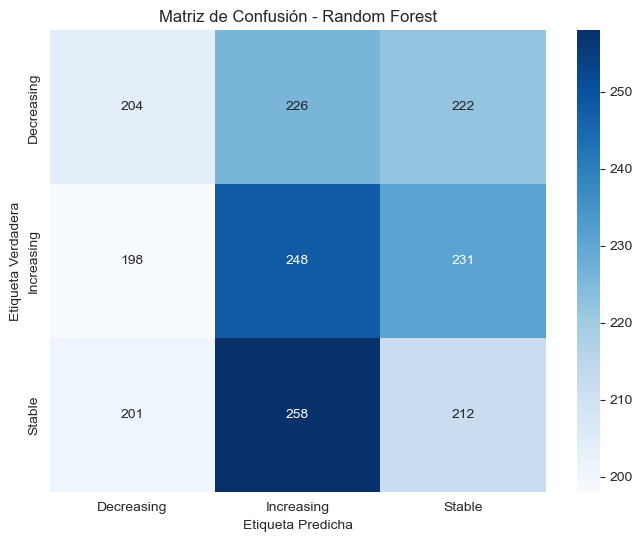

In [18]:
# ---
# 4.3. Modelo 3: Random Forest
# ---
print("\n--- 3. Entrenando Random Forest ---")

# Creamos el pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Entrenar el modelo
pipeline_rf.fit(X_train, y_train)

# Predecir
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluar
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"Resultados de Random Forest:")
print(f"  Precision (Macro): {precision_rf:.4f}")
print(f"  Recall (Macro):    {recall_rf:.4f}")
print(f"  F1-Score (Macro):  {f1_rf:.4f}")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

# Guardar resultados
all_results.append({
    'Model': 'Random Forest',
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf
})

# Graficar Matriz de Confusión
plot_confusion_matrix(y_test, y_pred_rf, class_labels, 'Matriz de Confusión - Random Forest')


--- 5. Comparación Final de Modelos ---
Tabla Resumen de Métricas (Macro Average):
               Precision  Recall  F1-Score
Model                                     
Decision Tree     0.3305  0.3304    0.3304
SVM (Tuned)       0.3368  0.3367    0.3358
Random Forest     0.3320  0.3317    0.3315


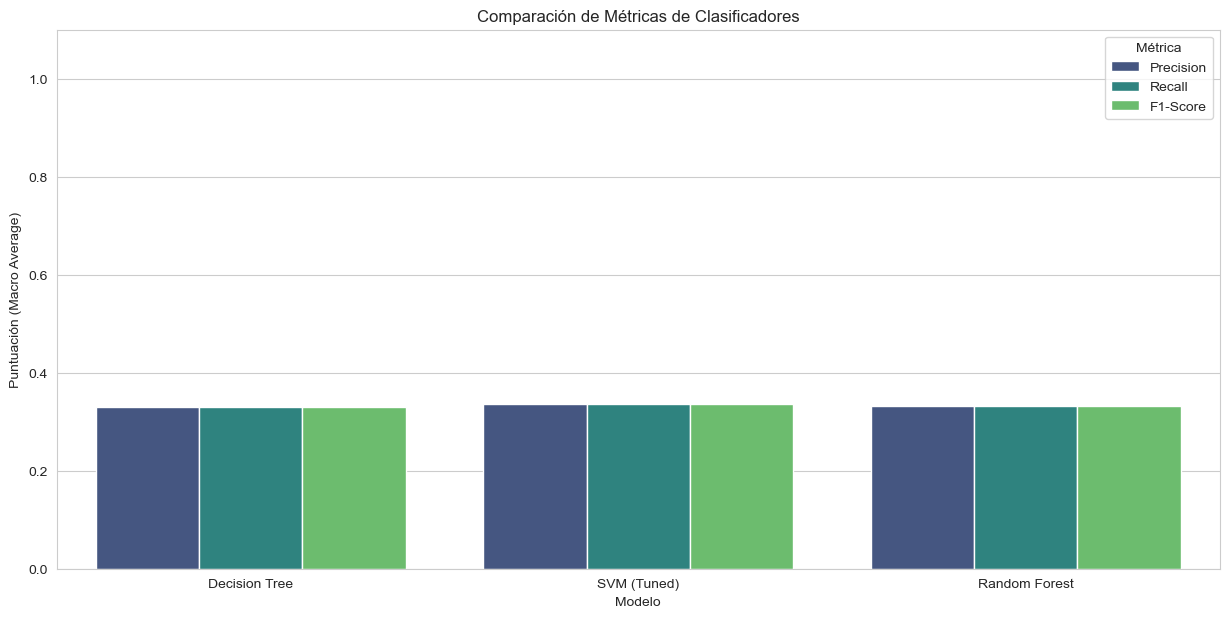

In [19]:
# --- PASO 5: Comparación Experimental ---

print("\n--- 5. Comparación Final de Modelos ---")

# 5.1. Tabla Resumen
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Model')

print("Tabla Resumen de Métricas (Macro Average):")
print(results_df.round(4)) # Redondear a 4 decimales

# 5.2. Visualización de la Comparación
# Re-organizamos el DataFrame para que sea fácil de graficar con seaborn
results_melted = results_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(15, 7))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Comparación de Métricas de Clasificadores')
plt.ylabel('Puntuación (Macro Average)')
plt.xlabel('Modelo')
plt.ylim(0, 1.1) # Poner el eje y de 0 a 1.1 para mejor visualización
plt.legend(title='Métrica', loc='upper right')
plt.show()